In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize scalers outside the dataset class
length_scaler = StandardScaler()
cptu_scaler = StandardScaler()
output_scaler1 = StandardScaler()
output_scaler2 = StandardScaler()

class BoreholeDataset(Dataset):
    def __init__(self, csv_file, length_scaler, cptu_scaler, output_scaler1, output_scaler2, fit_scalers=True):
        # Load the data
        data = pd.read_csv(csv_file)

        # Extracting RBC, CPTu, and Output columns
        self.RBC = data.iloc[:, 0].values.reshape(-1, 1) # requireed bearing capacity input
        self.cptu_data = data.iloc[:, 1:6163].values # CPTU inputs
        self.outputs1 = data.iloc[:, 6163].values.reshape(-1, 1) ## length
        self.outputs2 = data.iloc[:, 6164].values.reshape(-1, 1) ## diameter

        # Scale the data if required
        if fit_scalers:
            self.RBC = length_scaler.fit_transform(self.RBC)
            self.cptu_data = cptu_scaler.fit_transform(self.cptu_data)
            self.outputs1 = output_scaler1.fit_transform(self.outputs1)
            self.outputs2 = output_scaler2.fit_transform(self.outputs2)
        else:
            self.RBC = length_scaler.transform(self.RBC)
            self.cptu_data = cptu_scaler.transform(self.cptu_data)
            self.outputs1 = output_scaler1.transform(self.outputs1)
            self.outputs2 = output_scaler2.transform(self.outputs2)

        # Convert numpy arrays to tensors
        self.RBC = torch.tensor(self.RBC, dtype=torch.float32)
        self.cptu_data = torch.tensor(self.cptu_data, dtype=torch.float32)
        self.outputs1 = torch.tensor(self.outputs1, dtype=torch.float32)
        self.outputs2 = torch.tensor(self.outputs2, dtype=torch.float32)

    def __len__(self):
        return len(self.outputs1)

    def __getitem__(self, idx):
        # Returning tensors that will be automatically sent to the device during the batch gathering by the DataLoader
        return self.RBC[idx], self.cptu_data[idx], self.outputs1[idx], self.outputs2[idx]


# Prepare datasets and loaders
train_dataset = BoreholeDataset('Stage_4_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler1,
                                output_scaler2, fit_scalers=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = BoreholeDataset('Stage_4_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler1, output_scaler2, fit_scalers=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)




# # Create a DataLoader
# data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # adjust batch_size as needed
# 
# # Iterate through some batches
# for i, (RBC, cptu_data, output1, output2) in enumerate(data_loader):
#     print(f"Batch {i + 1}")
#     print("Output2 values:")
#     print(output2)
#     if i == 2:  # Just print 3 batches for checking
#         break


import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class TwoBranchMLP(nn.Module):
    def __init__(self, length_features, cptu_features, length_neurons, cptu_neurons, dropout_rate=0.5):
        super(TwoBranchMLP, self).__init__()

        # Dynamically create layers for the CPTu branch with batch normalization
        self.cptu_branch = self.create_branch(cptu_features, cptu_neurons, dropout_rate)

        # Dynamically create layers for the Length branch with batch normalization
        self.length_branch = self.create_branch(length_features, length_neurons, dropout_rate)

        # Combine outputs from both branches
        # Assuming the last neuron size in both branches are meant to combine
        last_cptu_neurons = cptu_neurons[-1]
        last_length_neurons = length_neurons[-1]
        self.combined = nn.Sequential(
            nn.Linear(last_cptu_neurons + last_length_neurons, max(last_cptu_neurons, last_length_neurons)),
            nn.BatchNorm1d(max(last_cptu_neurons, last_length_neurons)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(max(last_cptu_neurons, last_length_neurons), 2)  # Output for two distinct values
        )

    def create_branch(self, input_features, neurons, dropout_rate):
        layers = []
        for i in range(len(neurons)):
            if i == 0:
                layers.append(nn.Linear(input_features, neurons[i]))
            else:
                layers.append(nn.Linear(neurons[i-1], neurons[i]))
            layers.extend([
                nn.BatchNorm1d(neurons[i]),
                nn.LeakyReLU(negative_slope=0.01),
                nn.Dropout(dropout_rate)
            ])
        return nn.Sequential(*layers)

    def forward(self, length_data, cptu_data):
        length_out = self.length_branch(length_data)
        cptu_out = self.cptu_branch(cptu_data)
        combined_in = torch.cat((length_out, cptu_out), dim=1)
        output = self.combined(combined_in)
        return output[:, 0].unsqueeze(1), output[:, 1].unsqueeze(1)

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)

# Example model initialization
length_neurons = [32, 32, 32]
cptu_neurons = [32, 32, 32]
model = TwoBranchMLP(1, 6162, length_neurons, cptu_neurons, 0.1)
model.apply(initialize_weights)


# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()




def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    model.train()  # Ensure the model is in training mode
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        total_train_loss = 0

        # Training phase
        for batch_idx, (rbc_data, cptu_data, output1, output2) in enumerate(train_loader):            
            optimizer.zero_grad()
            
            predicted_output1, predicted_output2 = model( rbc_data, cptu_data)
            
            loss1 = criterion(predicted_output1, output1)
            loss2 = criterion(predicted_output2, output2)
            loss = (loss1 + loss2) / 2  # Average the losses

            loss.backward()  # Backpropagate the errors
            optimizer.step()  # Update the model parameters

            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        loss_history.append(average_train_loss)


        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for rbc_data, cptu_data, output1, output2 in val_loader:
                
                predicted_output1, predicted_output2 = model(rbc_data, cptu_data)
                loss1 = criterion(predicted_output1, output1)
                loss2 = criterion(predicted_output2, output2)
                loss = (loss1 + loss2) / 2  # Average the losses
                total_val_loss += loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(average_val_loss)
        
        scheduler.step(average_val_loss)

    return loss_history, val_loss_history


loss_history1 = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)
print(loss_history1)
# 
# torch.save(model.state_dict(), "S4_model1.pth")
# 
# with open('S4_loss1.txt', 'w') as file:
#     for item in loss_history1:
#         file.write(f"{item}\n")

# from joblib import dump
# dump((length_scaler, cptu_scaler, output_scaler1, output_scaler2), 'S4_scalers.joblib')

([15.414029598236084], [6.982828299204509])


## Stage 4 - Analysing Results from HPC - Plotting Loss vs Batch during Training

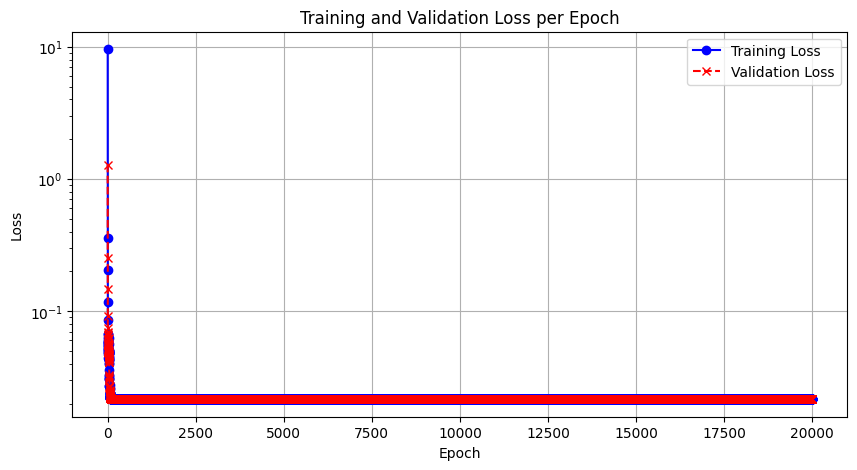

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the text file
file_path = 'S4_loss21.txt'

# Read the entire file into a single string
with open(file_path, 'r') as file:
    line = file.readline().strip()

# Remove the brackets and split the string into a list of numbers
cleaned_line = line.strip('[]')
numbers = list(map(float, cleaned_line.split(',')))

# Assuming alternate entries for training and validation losses
train_losses = numbers[0::2]  # Extract even index elements: training losses
val_losses = numbers[1::2]  # Extract odd index elements: validation losses

# Epochs array based on the shorter of the two lists
epochs = np.arange(1, min(len(train_losses), len(val_losses)) + 1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, val_losses, marker='x', linestyle='--', color='red', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()


## Stage 4 - Evaluating Validating an Testing Data using HPC weights

In [ ]:
## New Calculating Correlation Matrics

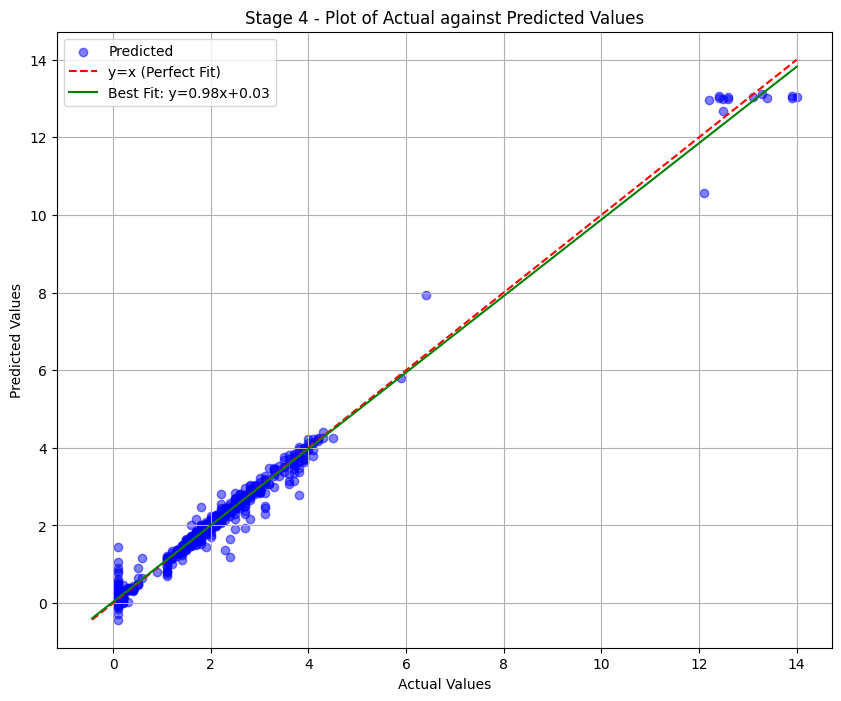

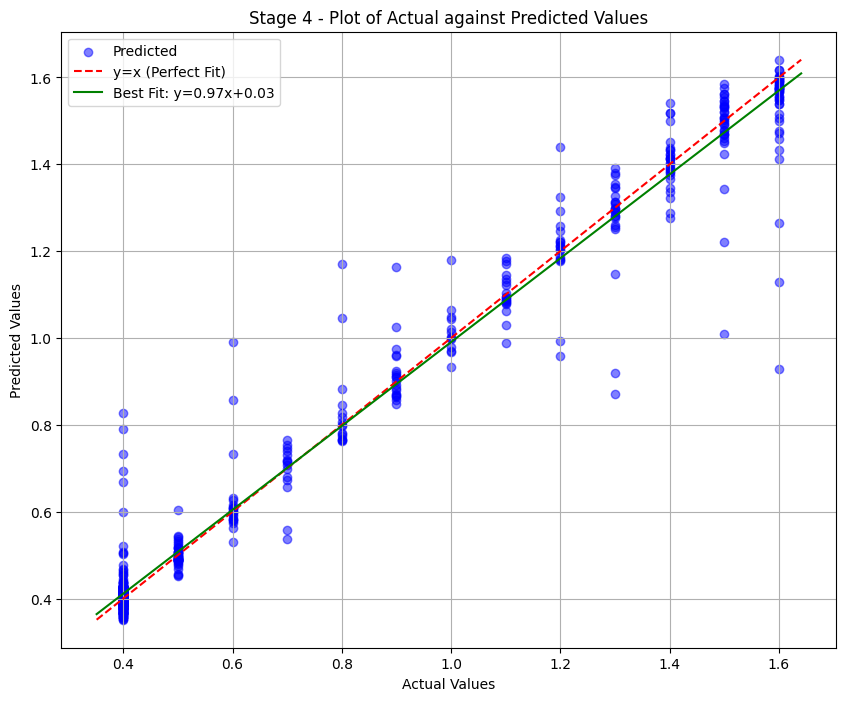

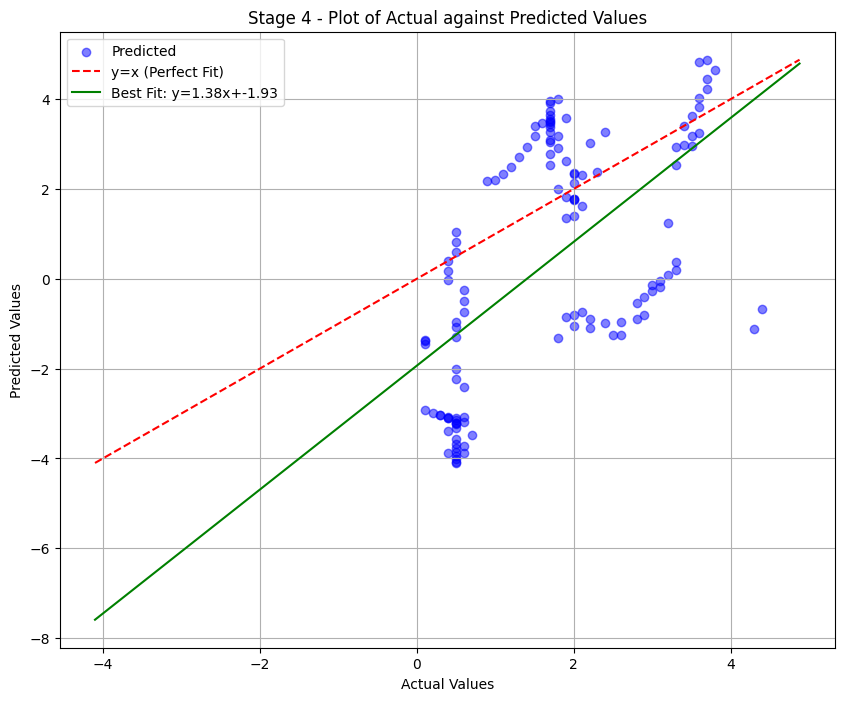

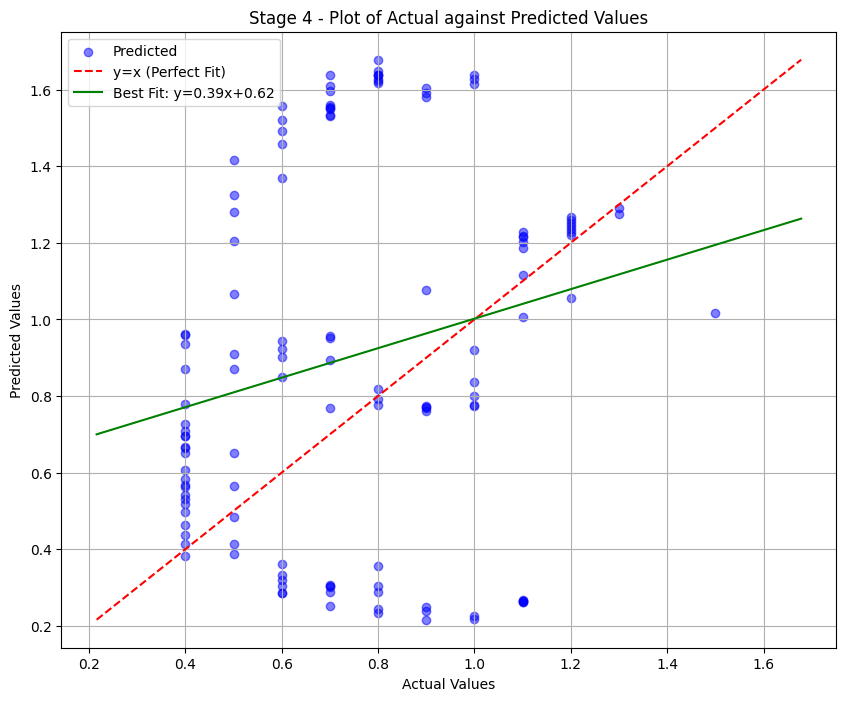

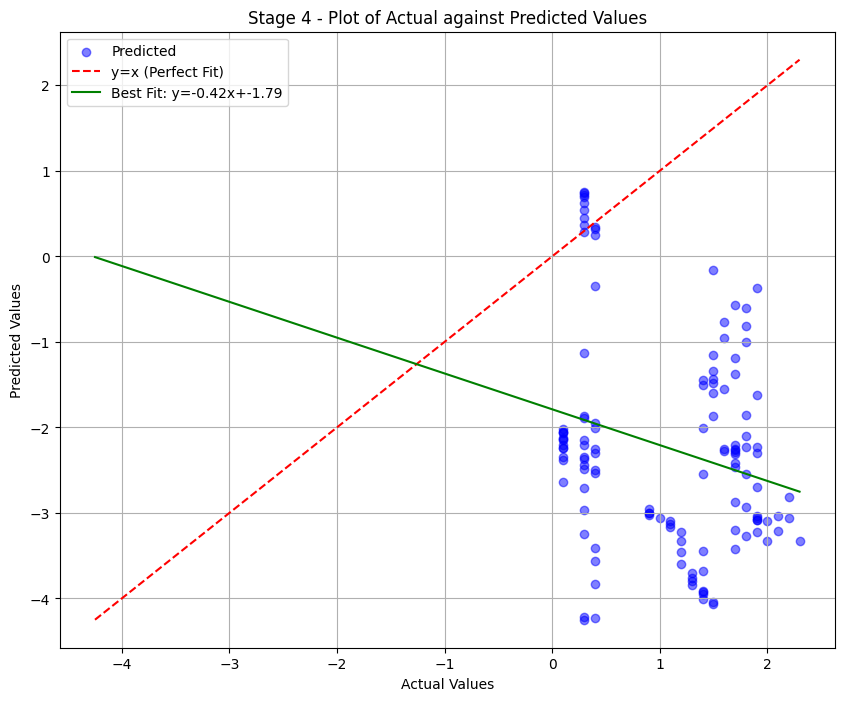

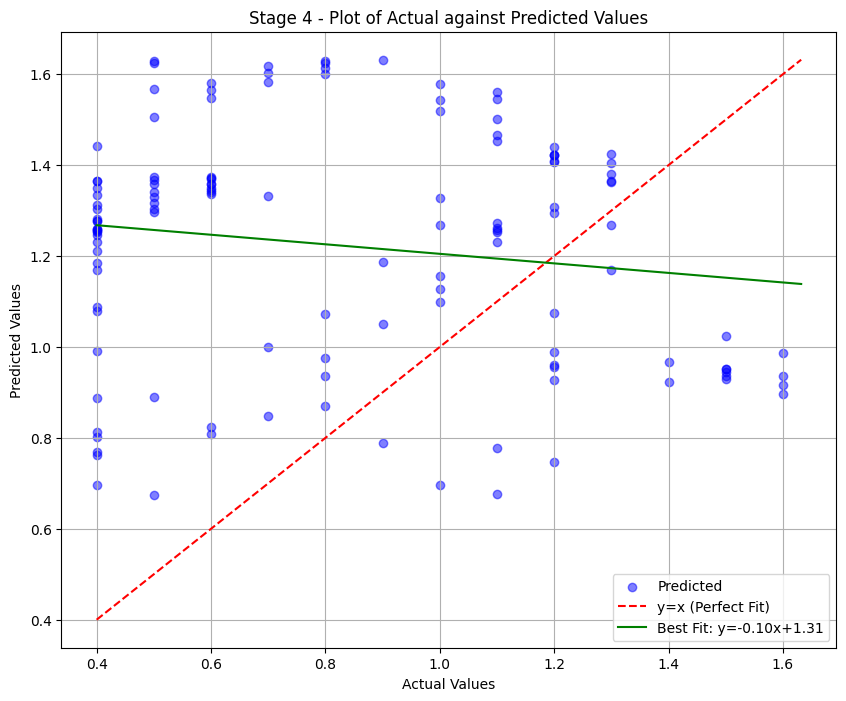

Training Data for Target 1 - MSE: 0.0503, R²: 0.9865, Relative Error: 33.556%
Training Data for Target 2 - MSE: 0.0057, R²: 0.9703, Relative Error: 16.003%
Training Data for Target 1 - MSE: 6.5809, R²: -4.0533, Relative Error: 444.143%
Training Data for Target 2 - MSE: 0.2649, R²: -2.6975, Relative Error: 589.475%
Training Data for Target 1 - MSE: 13.4595, R²: -27.2497, Relative Error: 979.234%
Training Data for Target 2 - MSE: 0.3875, R²: -1.7670, Relative Error: 363.105%


In [2]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from joblib import load

# Load model and scalers
# model = YourModelClass()  # Ensure to define your model class correctly
model.load_state_dict(torch.load('S4_model21.pth'))
model.eval()

length_scaler, cptu_scaler, output_scaler1, output_scaler2 = load('S4_scalers21.joblib')

def process_data(csv_file, length_scaler, cptu_scaler, output_scaler1, output_scaler2):
    data = pd.read_csv(csv_file)
    inputs = torch.tensor(length_scaler.transform(data.iloc[:, 0].values.reshape(-1, 1)), dtype=torch.float32)
    CPTu = torch.tensor(cptu_scaler.transform(data.iloc[:, 1:6163].values), dtype=torch.float32)
    target1 = torch.tensor(output_scaler1.transform(data.iloc[:, 6163].values.reshape(-1, 1)), dtype=torch.float32)
    target2 = torch.tensor(output_scaler2.transform(data.iloc[:, 6164].values.reshape(-1, 1)), dtype=torch.float32)
    return DataLoader(TensorDataset(inputs, CPTu, target1, target2), batch_size=64, shuffle=False)

# Load your datasets
train_loader = process_data('Stage_4_traind_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler1, output_scaler2)
val_loader = process_data('Stage_4_vald_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler1, output_scaler2)
test_loader = process_data('Stage_4_testd_merged_reduced.csv', length_scaler, cptu_scaler, output_scaler1, output_scaler2)


import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(filename, actuals, predictions, title='Actual vs. Predicted', actual_scaler=None, prediction_scaler=None):
    # If scalers are provided, inverse transform the data
    if actual_scaler is not None:
        actuals = actual_scaler.inverse_transform(actuals.reshape(-1, 1)).flatten()
    if prediction_scaler is not None:
        predictions = prediction_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Flatten arrays to ensure they are 1D
    actuals = actuals.flatten()
    predictions = predictions.flatten()

    # Create a scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 8))
    plt.scatter(actuals, predictions, alpha=0.5, color='blue', label='Predicted')

    # Plot the identity line
    max_val = max(max(actuals), max(predictions))
    min_val = min(min(actuals), min(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x (Perfect Fit)')

    # Calculate the line of best fit
    coefficients = np.polyfit(actuals, predictions, 1)
    polynomial = np.poly1d(coefficients)
    trendline = polynomial(np.linspace(min_val, max_val, 100))
    plt.plot(np.linspace(min_val, max_val, 100), trendline, 'g-', label=f'Best Fit: y={coefficients[0]:.2f}x+{coefficients[1]:.2f}')

    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Stage 4 - Plot of Actual against Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename}.png', dpi=300)
    plt.show()





def evaluate_model(filename, data_loader, output_scaler1, output_scaler2):
    total_mse1 = 0
    total_mse2 = 0
    total_samples = 0
    preds1, preds2, actuals1, actuals2 = [], [], [], []
    relative_errors1, relative_errors2 = [], []

    with torch.no_grad():
        for inputs, CPTu, targets1, targets2 in data_loader:
            outputs1, outputs2 = model(inputs, CPTu)

            # Inverse transform the outputs and targets for MSE calculation
            outputs1_rescaled = output_scaler1.inverse_transform(outputs1.numpy())
            targets1_rescaled = output_scaler1.inverse_transform(targets1.numpy())
            outputs2_rescaled = output_scaler2.inverse_transform(outputs2.numpy())
            targets2_rescaled = output_scaler2.inverse_transform(targets2.numpy())

            # Compute MSE on rescaled data
            mse1 = mean_squared_error(targets1_rescaled, outputs1_rescaled)
            mse2 = mean_squared_error(targets2_rescaled, outputs2_rescaled)
            total_mse1 += mse1 * inputs.size(0)
            total_mse2 += mse2 * inputs.size(0)
            total_samples += inputs.size(0)

            preds1.append(outputs1)
            actuals1.append(targets1)
            preds2.append(outputs2)
            actuals2.append(targets2)

            # Compute relative error on scaled data
            relative_error1 = np.abs((targets1.numpy() - outputs1.numpy()) / targets1.numpy())
            relative_error2 = np.abs((targets2.numpy() - outputs2.numpy()) / targets2.numpy())
            valid_re1 = relative_error1[~np.isinf(relative_error1)]
            valid_re2 = relative_error2[~np.isinf(relative_error2)]
            relative_errors1.extend(valid_re1)
            relative_errors2.extend(valid_re2)

    all_preds1 = torch.cat(preds1).numpy()
    all_actuals1 = torch.cat(actuals1).numpy()
    all_preds2 = torch.cat(preds2).numpy()
    all_actuals2 = torch.cat(actuals2).numpy()
    
    #Plotting graphs
    plot_actual_vs_predicted(filename, all_actuals1, all_preds1, 'Lengths - Actual vs. Predicted',output_scaler1, output_scaler1)
    plot_actual_vs_predicted(filename, all_actuals2, all_preds2, 'Diameters - Actual vs. Predicted', output_scaler2, output_scaler2)
    
    # Calculate total MSE
    total_mse1 /= total_samples
    total_mse2 /= total_samples
    
    # Calculate R² score on scaled data
    r2_1 = r2_score(all_actuals1, all_preds1)
    r2_2 = r2_score(all_actuals2, all_preds2)

    # Calculate mean relative error on scaled data
    mean_re1 = np.mean(relative_errors1) if len(relative_errors1) > 0 else np.inf
    mean_re2 = np.mean(relative_errors2) if len(relative_errors2) > 0 else np.inf

    return (total_mse1, r2_1, mean_re1), (total_mse2, r2_2, mean_re2)



# Call the function
(train_metrics1, train_metrics2) = evaluate_model('S4_Training_data_pred_plot', train_loader, output_scaler1, output_scaler2)
(val_metrics1, val_metrics2) = evaluate_model('S4_Validing_data_pred_plot', val_loader, output_scaler1, output_scaler2)
(test_metrics1, test_metrics2) = evaluate_model('S4_Testing_data_pred_plot', test_loader, output_scaler1, output_scaler2)
# Unpack the results for each target
train_mse1, train_r2_1, train_rel_error1 = train_metrics1
train_mse2, train_r2_2, train_rel_error2 = train_metrics2

val_mse1, val_r2_1, val_rel_error1 = val_metrics1
val_mse2, val_r2_2, val_rel_error2 = val_metrics2

test_mse1, test_r2_1, test_rel_error1 = test_metrics1
test_mse2, test_r2_2, test_rel_error2 = test_metrics2


# Print the results
print(f"Training Data for Target 1 - MSE: {train_mse1:.4f}, R²: {train_r2_1:.4f}, Relative Error: {train_rel_error1*100:.3f}%") ## Length
print(f"Training Data for Target 2 - MSE: {train_mse2:.4f}, R²: {train_r2_2:.4f}, Relative Error: {train_rel_error2*100:.3f}%") ## Diameter

print(f"Training Data for Target 1 - MSE: {val_mse1:.4f}, R²: {val_r2_1:.4f}, Relative Error: {val_rel_error1*100:.3f}%")
print(f"Training Data for Target 2 - MSE: {val_mse2:.4f}, R²: {val_r2_2:.4f}, Relative Error: {val_rel_error2*100:.3f}%")

print(f"Training Data for Target 1 - MSE: {test_mse1:.4f}, R²: {test_r2_1:.4f}, Relative Error: {test_rel_error1*100:.3f}%")
print(f"Training Data for Target 2 - MSE: {test_mse2:.4f}, R²: {test_r2_2:.4f}, Relative Error: {test_rel_error2*100:.3f}%")



# To access the final model weights after evaluation:
final_weights = model.state_dict()  # This dictionary holds all weights
# You can save these weights or print t


## Plotting graph of training data - Training Data

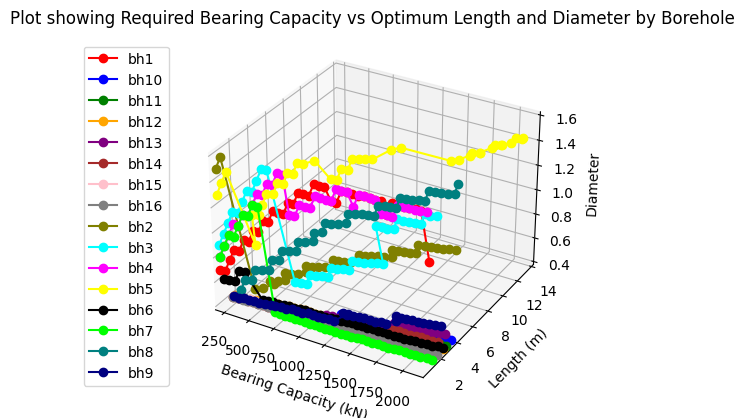

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
df1 = pd.read_csv('Stage_4_traind_merged_reduced.csv', header=0)

# Add a column to identify each borehole group
cycle_length = 16
borehole_labels = ['bh' + str(i+1) for i in range(cycle_length)]
df1['Borehole'] = np.tile(borehole_labels, int(len(df1)/cycle_length))

# Group data by boreholes
groups1 = df1.groupby('Borehole')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set a unique color for each borehole
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 
          'olive', 'cyan', 'magenta', 'yellow', 'black', 'lime', 'teal', 'navy']

# Loop through each group to plot for the first dataset
for color, (name, group) in zip(colors, groups1):
    x = group.iloc[:, 0]  # Assuming the first column is X after headers
    y = group.iloc[:, 6164 - 1]
    z = group.iloc[:, 6165 - 1]
    ax.plot(x, y, z, color=color, label=name, marker='o')  # Label every group

# Adjust axis limits if needed
ax.set_xlim([df1.iloc[:, 0].min(), df1.iloc[:, 0].max()])
ax.set_ylim([df1.iloc[:, 6164 - 1].min(), df1.iloc[:, 6164 - 1].max()])
ax.set_zlim([df1.iloc[:, 6165 - 1].min(), df1.iloc[:, 6165 - 1].max()])

# Labeling axes
ax.set_xlabel('Bearing Capacity (kN)')
ax.set_ylabel('Length (m)')
ax.set_zlabel('Diameter')

plt.title('Plot showing Required Bearing Capacity vs Optimum Length and Diameter by Borehole')

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(-.3, 0.5))
plt.savefig('Plot of Stage 4 - Training Data - Required Bearing Capacity vs Optimum Pile Length', dpi=300, bbox_inches='tight')

plt.show()



In [11]:
## Old code - ignore

Group sizes in test data: {'bh1': 43, 'bh2': 43, 'bh3': 43}
Group sizes in validation data: {'bh1': 43, 'bh2': 43, 'bh3': 43}


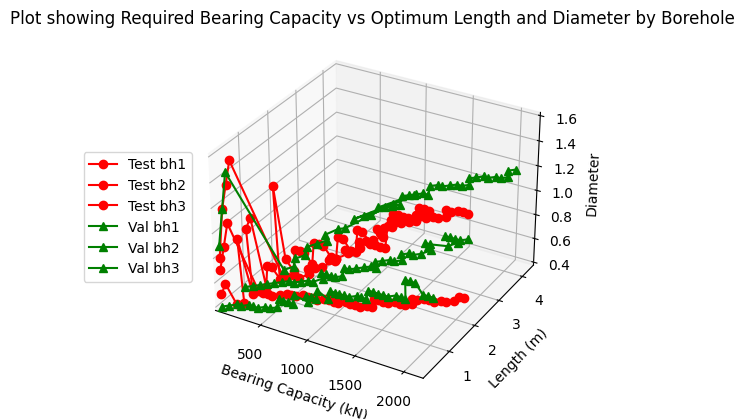

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load datasets
df1 = pd.read_csv('Stage_4_testd_merged_reduced.csv', header=0)
df2 = pd.read_csv('Stage_4_vald_merged_reduced.csv', header=0)

# Add a column to identify each borehole group
cycle_length = 3  # Number of boreholes
# Ensure that we tile enough labels to cover all entries
df1['Borehole'] = np.tile(borehole_labels, (len(df1) // cycle_length) + (len(df1) % cycle_length > 0))
df2['Borehole'] = np.tile(borehole_labels, (len(df2) // cycle_length) + (len(df2) % cycle_length > 0))

# Group data by boreholes
groups1 = df1.groupby('Borehole')
groups2 = df2.groupby('Borehole')

# Diagnostic print to check group sizes
print("Group sizes in test data:", {name: len(group) for name, group in groups1})
print("Group sizes in validation data:", {name: len(group) for name, group in groups2})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set a unique color for each borehole
colors1 = ['red']*3
colors2 = ['green']*3

# Loop through each group to plot for the first dataset (test)
for color, (name, group) in zip(colors1, groups1):
    x = group.iloc[:, 0]  # Assuming the first column is X after headers
    y = group.iloc[:, 6164 - 1]  # Adjust the column index if needed
    z = group.iloc[:, 6165 - 1]  # Adjust the column index if needed
    ax.plot(x, y, z, color=color, label=f'Test {name}', marker='o')

# Loop through each group to plot for the second dataset (validation)
for color, (name, group) in zip(colors2, groups2):
    x = group.iloc[:, 0]
    y = group.iloc[:, 6164 - 1]
    z = group.iloc[:, 6165 - 1]
    ax.plot(x, y, z, color=color, label=f'Val {name}', marker='^')

# Adjust axis limits
min_x = min(df1.iloc[:, 0].min(), df2.iloc[:, 0].min())
max_x = max(df1.iloc[:, 0].max(), df2.iloc[:, 0].max())
min_y = min(df1.iloc[:, 6164 - 1].min(), df2.iloc[:, 6164 - 1].min())
max_y = max(df1.iloc[:, 6164 - 1].max(), df2.iloc[:, 6164 - 1].max())
min_z = min(df1.iloc[:, 6165 - 1].min(), df2.iloc[:, 6165 - 1].min())
max_z = max(df1.iloc[:, 6165 - 1].max(), df2.iloc[:, 6165 - 1].max())

ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
ax.set_zlim([min_z, max_z])

# Labeling axes
ax.set_xlabel('Bearing Capacity (kN)')
ax.set_ylabel('Length (m)')
ax.set_zlabel('Diameter')

plt.title('Plot showing Required Bearing Capacity vs Optimum Length and Diameter by Borehole')

# Move the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(-.3, 0.5))
plt.savefig('Combined Plot of Stage 4 Data - Required Bearing Capacity vs Optimum Pile Length', dpi=300, bbox_inches='tight')

plt.show()
